>보스턴 집값 예측모형을 신경망 기반으로 구현하시오.

>- 범주형을 제외한 변수는 MinMax 스케일링을 수행하시오.
>- 학습 수행 전 다중공선성을 제거하시오.
>- 위 조건에 대하여 다중선형회귀와 다항선형회귀 모형으로 구현하시오.

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

from datetime import datetime as dt
from kerastuner import Hyperband

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import (
    History,
    EarlyStopping,
    ReduceLROnPlateau,
)

from tensorflow.keras.optimizers import Adam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

In [3]:
df = my_minmax_scaler(data=origin, yname='MEDV')
my_pretty_table(data=df.head())

+----+-------------+------+-----------+--------+----------+----------+----------+----------+-----------+-----------+-----------+----------+-----------+--------+
|    |        CRIM |   ZN |     INDUS |   CHAS |      NOX |       RM |      AGE |      DIS |       RAD |       TAX |   PTRATIO |        B |     LSTAT |   MEDV |
|----+-------------+------+-----------+--------+----------+----------+----------+----------+-----------+-----------+-----------+----------+-----------+--------|
|  0 |           0 | 0.18 | 0.0678152 |      0 | 0.314815 | 0.577505 | 0.641607 | 0.269203 |         0 |  0.208015 |  0.287234 |        1 | 0.0896799 |     24 |
|  1 | 0.000235923 |    0 |  0.242302 |      0 |  0.17284 | 0.547998 | 0.782698 | 0.348962 | 0.0434783 |  0.104962 |  0.553191 |        1 |   0.20447 |   21.6 |
|  2 | 0.000235698 |    0 |  0.242302 |      0 |  0.17284 | 0.694386 | 0.599382 | 0.348962 | 0.0434783 |  0.104962 |  0.553191 | 0.989737 | 0.0634658 |   34.7 |
|  3 | 0.000292796 |    0 | 0.0630

In [4]:
df2 = my_vif_filter(df,yname='MEDV')
my_pretty_table(df2.head())

{'CRIM': 2.0981756785047603, 'ZN': 2.845295035664714, 'INDUS': 13.291853296191007, 'CHAS': 1.1538031283731762, 'NOX': 12.784831290573695, 'RM': 16.662010623285585, 'AGE': 19.608990927855437, 'DIS': 7.977452910783912, 'RAD': 14.588185255245303, 'TAX': 24.552717485451183, 'PTRATIO': 13.341630723264947, 'B': 16.01271026060846, 'LSTAT': 8.623874677579794}
{'CRIM': 2.0979435823438655, 'ZN': 2.70323099407003, 'INDUS': 10.62698633458336, 'CHAS': 1.1368443543649596, 'NOX': 12.69607304564116, 'RM': 16.547450632163333, 'AGE': 19.58747834714656, 'DIS': 7.9688220737043425, 'RAD': 5.491364636494406, 'PTRATIO': 13.240686525527048, 'B': 16.006878410821955, 'LSTAT': 8.62319168692155}
{'CRIM': 2.0975958648632544, 'ZN': 2.6668017952163354, 'INDUS': 10.605199295864633, 'CHAS': 1.1342751797681199, 'NOX': 11.364322311729063, 'RM': 13.662477340207142, 'DIS': 7.446219692065394, 'RAD': 5.431334188101622, 'PTRATIO': 12.98988255320924, 'B': 15.585779535656872, 'LSTAT': 7.088307931128581}
{'CRIM': 2.078619911009

In [6]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'MEDV')
rows, cols = x_train.shape
rows, cols

(404, 8)

In [7]:
def tf_build(hp) -> Sequential:
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],
    )

    return model

In [8]:
tuner = Hyperband(
    hypermodel=tf_build,    # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_mae",    # 최적화 기준값
    max_epochs=10,
    factor=3,
    seed=get_random_state(),
    directory="D:\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [9]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 9 Complete [00h 00m 02s]
val_mae: 21.88775062561035

Best val_mae So Far: 5.565134525299072
Total elapsed time: 00h 00m 15s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 11.6398 | 2.43928 |
| test  | 22.4047 | 2.97588 |
+-------+---------+---------+


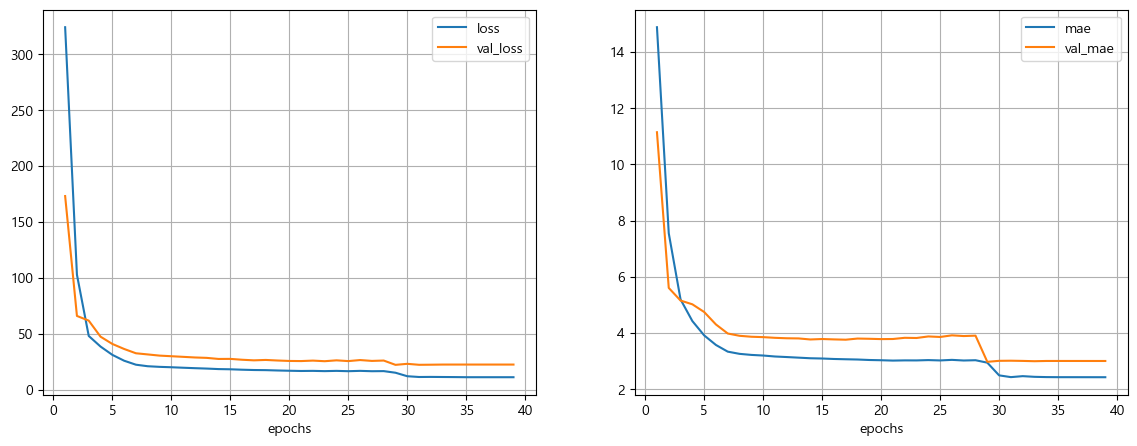

In [10]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)

In [11]:
df3 = my_poly_features(df2,ignore='MEDV')
my_pretty_table(df3.head())

+----+-------------+------+-----------+--------+----------+----------+-----------+-----------+-------------+-----------+--------------+-------------+-------------+-------------+-------------+--------------+--------+------------+-----------+----------+-----------+----------+------------+------------+--------------+------------+-------------+-------------+---------------+----------+-----------+------------+------------+--------------+----------+----------+-----------+------------+-----------+-----------+-------------+------------+-------------+------------+--------+
|    |        CRIM |   ZN |     INDUS |   CHAS |       RM |      DIS |       RAD |     LSTAT |      CRIM^2 |   CRIM ZN |   CRIM INDUS |   CRIM CHAS |     CRIM RM |    CRIM DIS |    CRIM RAD |   CRIM LSTAT |   ZN^2 |   ZN INDUS |   ZN CHAS |    ZN RM |    ZN DIS |   ZN RAD |   ZN LSTAT |    INDUS^2 |   INDUS CHAS |   INDUS RM |   INDUS DIS |   INDUS RAD |   INDUS LSTAT |   CHAS^2 |   CHAS RM |   CHAS DIS |   CHAS RAD |   CHAS 

In [14]:
x_train, x_test, y_train, y_test = my_train_test_split(df3, 'MEDV')
rows, cols = x_train.shape
rows, cols

(404, 44)

In [15]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 9.18932 | 2.24797 |
| test  | 19.8567 | 2.87574 |
+-------+---------+---------+


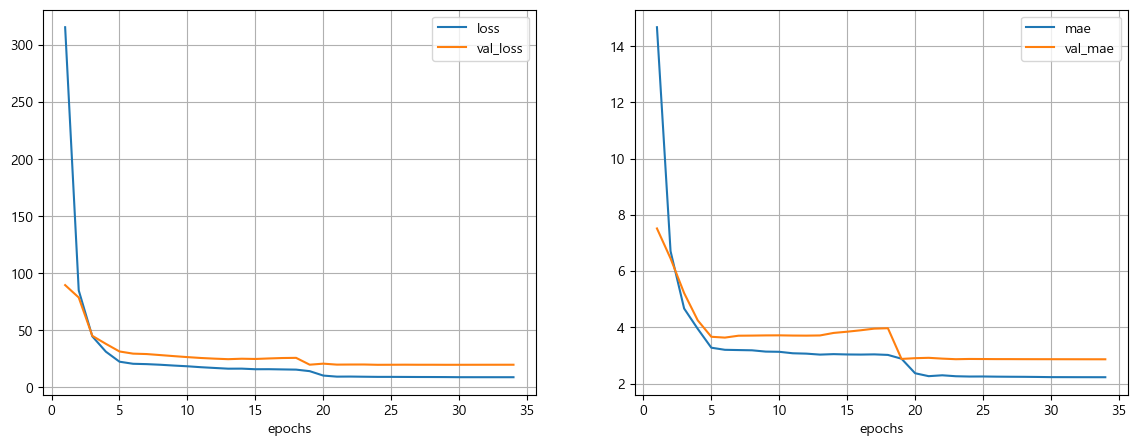

In [16]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)